#  Creating effective investment portfolios

In [1]:
%matplotlib inline

import pandas as pd
from pandas_datareader import data
import pandas_datareader
import numpy as np
import scipy as sc
import cvxopt
import portfolioopt
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
shares = data.DataReader(['AAPL','IBM','MSFT','GM','GOOG','GE'], 'yahoo',start='1/1/2010')
aapl = data.DataReader('AAPL', 'yahoo',start='1/1/2010')
ibm = data.DataReader('IBM', 'yahoo',start='1/1/2010')
msft = data.DataReader('MSFT', 'yahoo',start='1/1/2010')
gm = data.DataReader('GM', 'yahoo',start='1/1/2010')
goog = data.DataReader('goog', 'yahoo',start='1/1/2010')
ge = data.DataReader('ge', 'yahoo',start='1/1/2010')

In [3]:
aapl["change"]=aapl['Adj Close'].pct_change()
ibm["change"]=ibm['Adj Close'].pct_change()
msft["change"]=msft['Adj Close'].pct_change()
gm["change"]=gm['Adj Close'].pct_change()
goog["change"]=goog['Adj Close'].pct_change()
ge["change"]=ge['Adj Close'].pct_change()

In [4]:
aapl_days = (aapl.index[-1] - aapl.index[0]).days
aapl_cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (356.0/aapl_days)) - 1
ibm_days = (ibm.index[-1] - ibm.index[0]).days
ibm_cagr = ((((ibm['Adj Close'][-1]) / ibm['Adj Close'][1])) ** (356.0/ibm_days)) - 1
msft_days = (msft.index[-1] - msft.index[0]).days
msft_cagr = ((((msft['Adj Close'][-1]) / msft['Adj Close'][1])) ** (356.0/msft_days)) - 1
gm_days = (gm.index[-1] - gm.index[0]).days
gm_cagr = ((((gm['Adj Close'][-1]) / gm['Adj Close'][1])) ** (356.0/gm_days)) - 1
goog_days = (goog.index[-1] - goog.index[0]).days
goog_cagr = ((((goog['Adj Close'][-1]) / goog['Adj Close'][1])) ** (356.0/goog_days)) - 1
ge_days = (ge.index[-1] - ge.index[0]).days
ge_cagr = ((((ge['Adj Close'][-1]) / ge['Adj Close'][1])) ** (356.0/ge_days)) - 1

In [5]:
aapl_vol = aapl['change'].std()*sqrt(252)
ibm_vol = ibm['change'].std()*sqrt(252)
msft_vol = msft['change'].std()*sqrt(252)
gm_vol = gm['change'].std()*sqrt(252)
goog_vol = goog['change'].std()*sqrt(252)
ge_vol = ge['change'].std()*sqrt(252)

In [6]:
portfolio=pd.DataFrame({'mu':[aapl_cagr,ibm_cagr,msft_cagr,gm_cagr,goog_cagr,ge_cagr],
                        "vol":[aapl_vol,ibm_vol,msft_vol,gm_vol,goog_vol,ge_vol]},
                      index=['Apple',"IBM","MSFT","GM","Google","GE"])

In [7]:
portfolio

,mu,vol
Apple,0.221373,0.262305
IBM,0.058637,0.191345
MSFT,0.134117,0.231732
GM,0.026665,0.292294
Google,0.138920,0.250033
GE,0.140822,0.218382


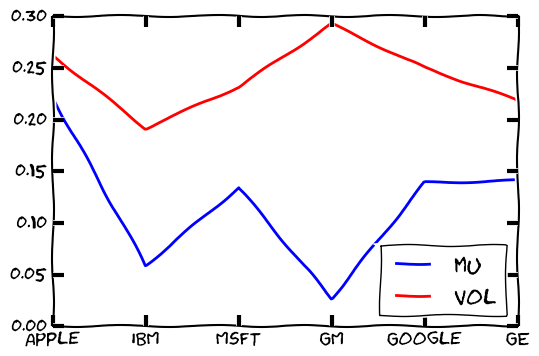

In [8]:
plt.xkcd()
portfolio.plot()

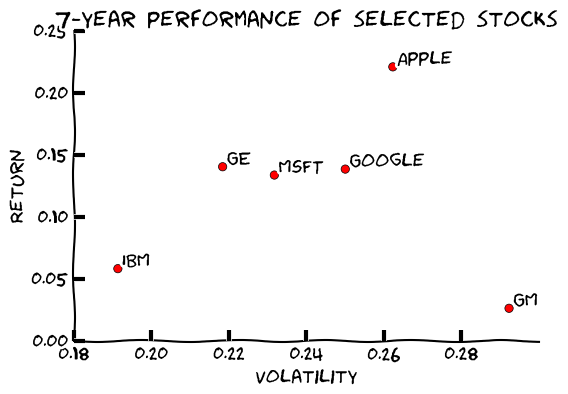

In [9]:
label=portfolio.index.values
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.plot(portfolio.vol.values,portfolio.mu.values,'ro')
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.title("7-year performance of selected stocks")
for x in range(len(label)):
    plt.annotate(label[x], xy = (portfolio.vol.values[x], portfolio.mu.values[x]), xytext = (3, 3), textcoords = 'offset points')
plt.show()

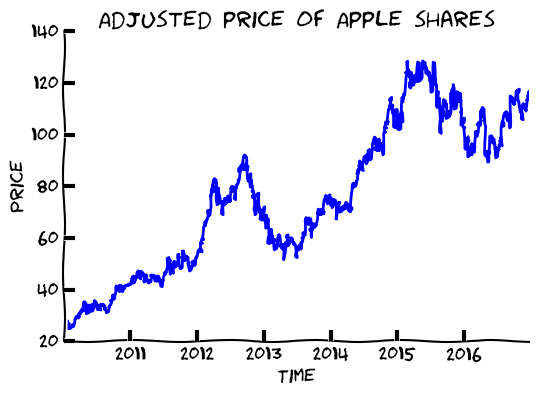

In [10]:
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.plot(aapl['Adj Close'])
plt.ylabel('Price')
plt.xlabel('Time')
plt.title("Adjusted price of Apple shares")
plt.show()

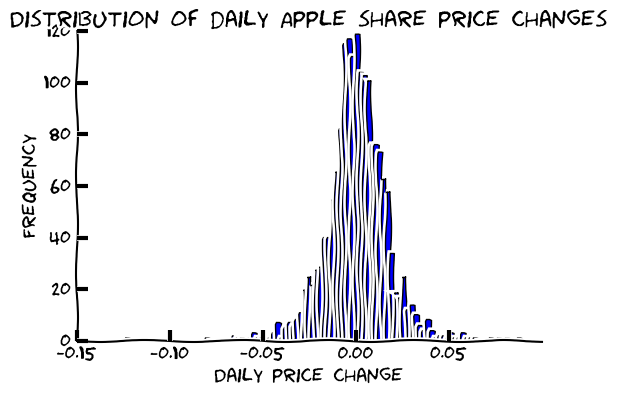

In [11]:
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.xlabel('Daily price change')
plt.ylabel('Frequency')
plt.title("Distribution of daily Apple share price changes")
plt.hist(aapl['change'].dropna().values,100)
plt.show()

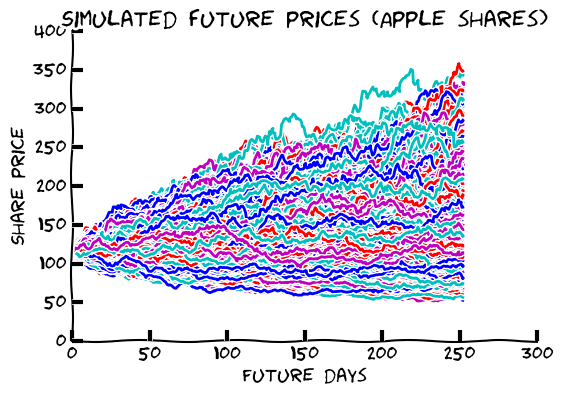

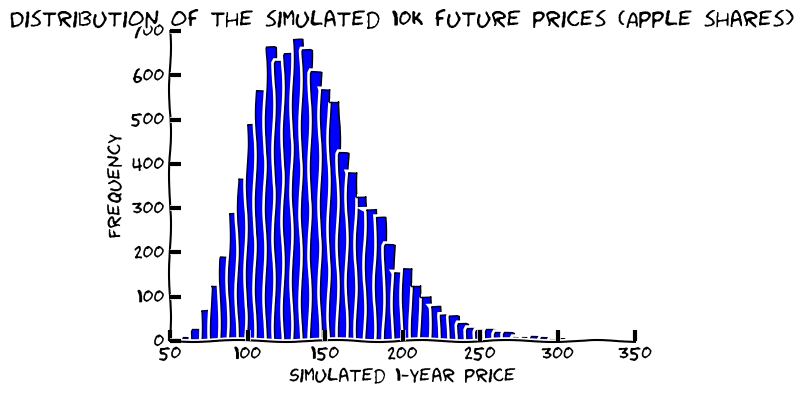

In [12]:
#set up empty list to hold our ending values for each simulated price series
result = []
 
#Define Variables
S = aapl['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
T = 252 #Number of trading days
mu = aapl_cagr #Return
vol = aapl_vol #Volatility

fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
 
#choose number of runs to simulate - I have chosen 10,000
for i in range(10000):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal((1+mu)**(1/T),vol/sqrt(T),T)
    #daily_returns=np.random.normal(aapl['change'].mean(),vol/sqrt(T),T)+1
 
    #set starting price and create price series generated by above random daily returns
    price_list = [S]
 
    for x in daily_returns:
        price_list.append(price_list[-1]*x)
 
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
 
    #append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])
 
#show the plot of multiple price series created above
plt.xlabel('Future days')
plt.ylabel('Share price')
plt.title("Simulated future prices (Apple shares)")
plt.ylim([0,400])
plt.show()
 
#create histogram of ending stock values for our mutliple simulations
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.hist(result,bins=50)
plt.xlabel('Simulated 1-year price')
plt.ylabel('Frequency')
plt.title("Distribution of the simulated 10k future prices (Apple shares)")
plt.show()

In [13]:
print("Expected price=",np.mean(result))
print("5% quantile =",np.percentile(result,5))
print("95% quantile =",np.percentile(result,95))

Expected price= 142.380796089
5% quantile = 89.8382697296
95% quantile = 211.769871152


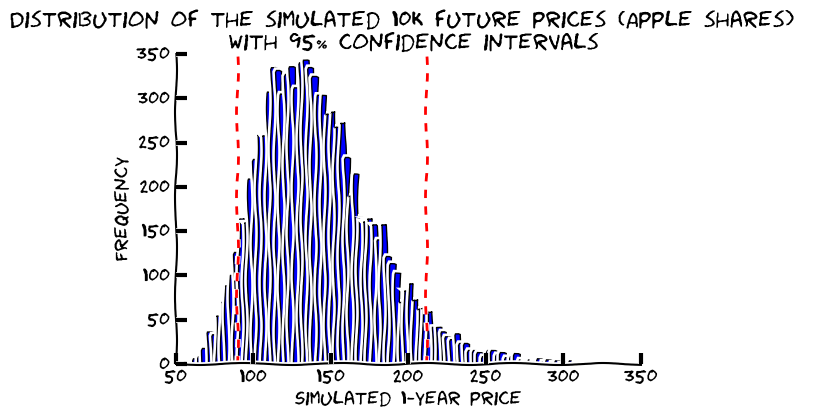

In [14]:
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.hist(result,bins=100)
plt.axvline(np.percentile(result,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(result,95), color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Simulated 1-year price')
plt.ylabel('Frequency')
plt.title("Distribution of the simulated 10k future prices (Apple shares) \n with 95% confidence intervals")
plt.show()